# **NLP pour la détection des langues**

**Objectif:**
Réaliser un système de détection de langue qui sera capable de détecter une langue donnée à partir un texte. _Ceci est un problème de classification de séquence de textes multi-classes_

### **Imports**

In [2]:
import sys
import os
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

In [58]:
# !pip install sentencepiece
import sentencepiece as spm
import tempfile

In [8]:
# Import* basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# ML libraries
from sklearn.model_selection  import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Custom libraries
from src.preprocess import preprocess_text, build_vocab, text_to_sequence, text_to_subword_sequence
from src.data_loader import LanguageDataset, SubwordLanguageDataset
from src.predict import get_predictions
from src.model import LanguageDetectorLSTM, BiLSTMSubword

# Graine aléatoire pour reproductibilité
np.random.seed(42)
torch.manual_seed(42)

In [57]:
import importlib
import src

importlib.reload(src)
importlib.reload(src.preprocess)
importlib.reload(src.data_loader)
importlib.reload(src.model)

<module 'src.model' from '/home/kevin/Documents/Collège LaCité/Cours IA en Informatique (51847)/Hiver 2026/Apprentissage profond appliqué avancé (IFM31115-0020-H2026)/Projets/language-detection-nlp/src/model.py'>

In [10]:
# PyTorch check
print(f'PyTorch version: {torch.__version__}')
print(f'GPU is_available ?: {torch.cuda.is_available()}')
if torch.cuda.is_available():
  print(f'GPU device: {torch.cuda.get_device_name(0)}')


PyTorch version: 2.10.0+cu128
GPU is_available ?: False


## **Exploration des données (EDA)**

In [11]:
# Charger le dataset
language_df = pd.read_csv('../data/raw/Language Detection.csv')
print("Dataset shape: ", language_df.shape)
print("\nAperću: ")
language_df.head(5)

Dataset shape:  (10337, 2)

Aperću: 


,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


In [12]:
# Infos
print("\n Infos sur le dataset:")
language_df.info()


 Infos sur le dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10337 entries, 0 to 10336
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      10337 non-null  object
 1   Language  10337 non-null  object
dtypes: object(2)
memory usage: 161.6+ KB


In [13]:
# Valeurs manquantes
print("\nValeurs manquantes:")
language_df.isnull().sum()


Valeurs manquantes:


Text        0
Language    0
dtype: int64

In [14]:
# Résumé statistique
print("\nRésumé statistique: ")
language_df.describe()


Résumé statistique: 


,Text,Language
count,10337,10337
unique,10267,17
top,mijn excuses.,English
freq,3,1385


<u>**Observations:**</u>
* Aucune valeur manquantes
* Taille du dataset: 10337x2
* Données structurées

In [15]:
# Analysons la distribution des langues
language_counts = language_df['Language'].value_counts()
print("Nombre uniques de langues: ", len(language_counts))
language_counts

Nombre uniques de langues:  17


Language
English       1385
French        1014
Spanish        819
Portugeese     739
Italian        698
Russian        692
Sweedish       676
Malayalam      594
Dutch          546
Arabic         536
Turkish        474
German         470
Tamil          469
Danish         428
Kannada        369
Greek          365
Hindi           63
Name: count, dtype: int64

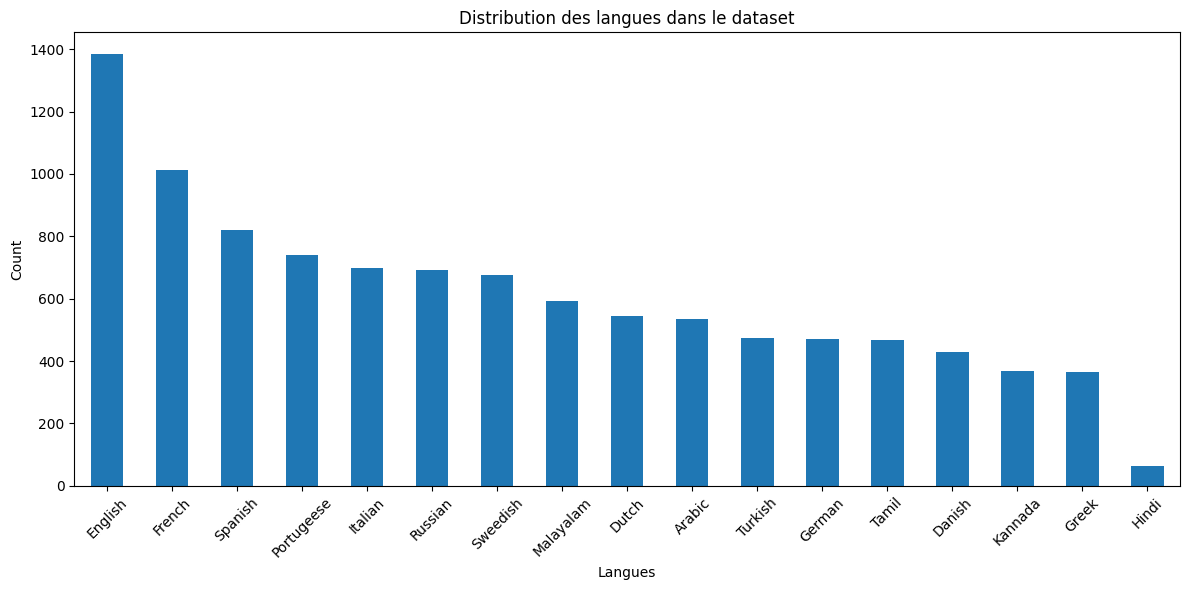

In [16]:
# Visualisation
plt.figure(figsize=(12, 6))
language_counts.plot(kind='bar')
plt.title('Distribution des langues dans le dataset')
plt.xlabel('Langues')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Déterminons la proportions des langues (nos classes) dans le dataset
print(f"\nLangue la plus fréquente: '{language_counts.index[0]}' ({language_counts.iloc[0]}) échantillons")
print(f"Langue moins fréquente: '{language_counts.index[-1]}' ({language_counts.iloc[-1]})")
print(f"Ratio (max/min): {language_counts.iloc[0]/language_counts.iloc[-1]:.2f}")


Langue la plus fréquente: 'English' (1385) échantillons
Langue moins fréquente: 'Hindi' (63)
Ratio (max/min): 21.98


## **Analyse des données de textes (colonne `Text`)**

In [18]:
# Analysons les texts
language_df['text_length'] = language_df['Text'].str.len()
language_df['word_count'] = language_df['Text'].str.split().str.len()

print("\nAperću: ")
language_df.head(5)


Aperću: 


,Text,Language,text_length,word_count
0,"Nature, in the broadest sense, is the natural...",English,85,13
1,"""Nature"" can refer to the phenomena of the phy...",English,87,16
2,"The study of nature is a large, if not the onl...",English,65,14
3,"Although humans are part of nature, human acti...",English,123,19
4,[1] The word nature is borrowed from the Old F...,English,194,31


In [19]:
# Évaluons les statistiques du texte par langue
length_stats = language_df.groupby('Language')['text_length'].agg(['mean', 'std', 'min', 'max'])
print("\nStats de longueur de textes par langues: ")
length_stats


Stats de longueur de textes par langues: 


,mean,std,min,max
Language,,,,
Arabic,99.192164,81.205879,1,581
Danish,91.252336,87.122148,3,737
Dutch,99.263736,85.088880,7,759
English,136.901083,83.397663,5,720
French,145.135108,103.826981,5,1168
German,74.702128,62.773500,6,455
Greek,106.260274,97.078991,5,733
Hindi,1209.190476,2833.621790,15,19088
Italian,142.157593,117.033151,4,1007


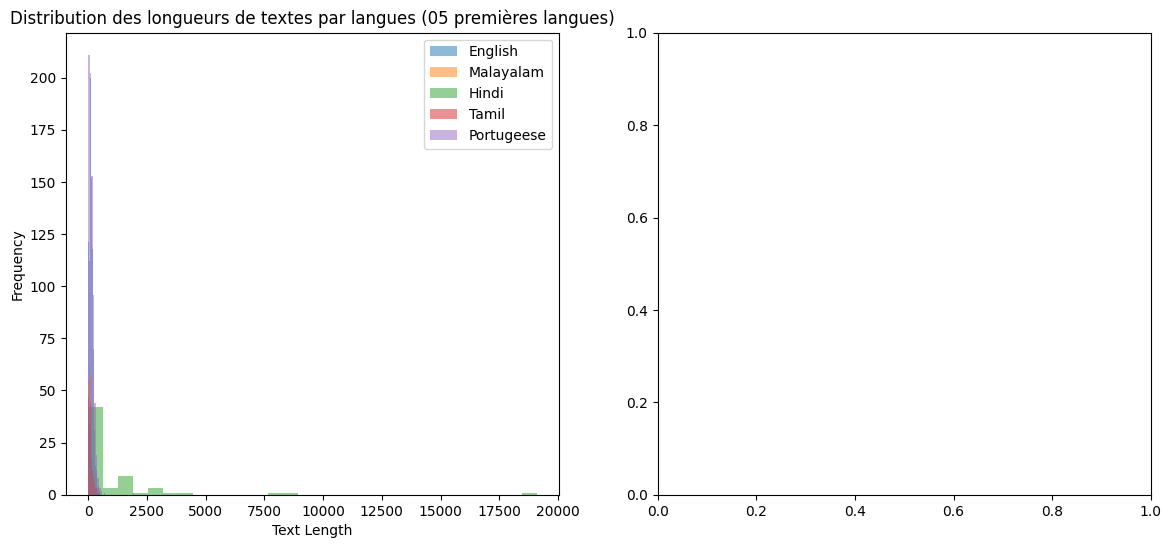

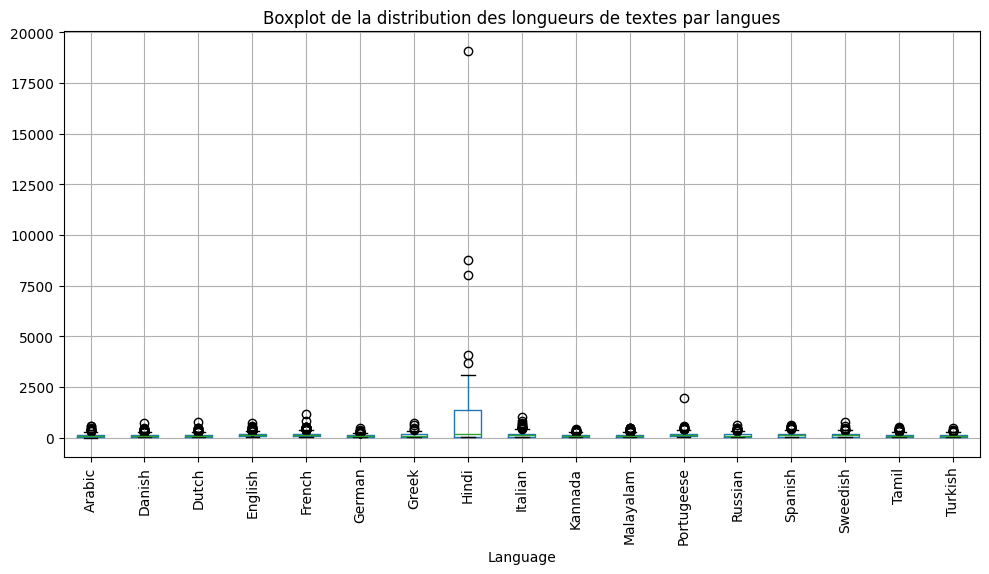

In [20]:
# Visualisons cette distribution
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for language in language_df['Language'].unique()[:5]:  # Show first 5 languages
    subset = language_df[language_df['Language'] == language]
    plt.hist(subset['text_length'], alpha=0.5, label=language, bins=30)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution des longueurs de textes par langues (05 premières langues)')

plt.subplot(1, 2, 2)
language_df.boxplot(column='text_length', by='Language', rot=90, figsize=(10, 6))
plt.title('Boxplot de la distribution des longueurs de textes par langues')
plt.suptitle('')
plt.tight_layout()
plt.show()

In [21]:
# Échantillon de text de chaque langue
print("\nÉchantillon de text de chaque langue:")
for language in language_df['Language'].unique():
  samples = language_df[language_df['Language'] == language]['Text'].head(5) # Juste 05 échantillons
  print(f"\n ---{language}---")
  for i, text in enumerate(samples, 1):
    print(f"{i}. {text[:100]}..." if len(text) > 100 else f"{i}. {text}")


Échantillon de text de chaque langue:

 ---English---
1.  Nature, in the broadest sense, is the natural, physical, material world or universe.
2. "Nature" can refer to the phenomena of the physical world, and also to life in general.
3. The study of nature is a large, if not the only, part of science.
4. Although humans are part of nature, human activity is often understood as a separate category from o...
5. [1] The word nature is borrowed from the Old French nature and is derived from the Latin word natura...

 ---Malayalam---
1. ഭൗതികപ്രപഞ്ചത്തെ മൊത്തത്തിൽ സൂചിപ്പിക്കുന്ന പദമാണ് പ്രകൃതി (ജർമൻ: Natur, ഫ്രഞ്ച്, ഇംഗ്ലീഷ്: Nature, ...
2. ഭൗതികപ്രതിഭാസങ്ങളും ജീവനും പ്രകൃതിയുടെ ഘടകങ്ങളാണ്.
3. മനുഷ്യനിർമിതമായ വസ്തുക്കളെ പ്രകൃതിയുടെ ഭാഗമായി കണക്കാക്കാറില്ല.
4. അവയെ കൃത്രിമം എന്ന് വിശേഷിപ്പിക്കുന്നുഅഭിപ്രായസ്വാതന്ത്ര്യം ഇംഗ്ലീഷ് പദമായ nature എന്നതിൻറെ ഉൽപത്തി ...
5. പ്രകൃതി എന്ന പദം പ്രപഞ്ചത്തെയും അതിലെ സമസ്ത പ്രതിഭാസങ്ങളെയും ഉൾ‍ക്കൊള്ളുന്നു.

 ---Hindi---
1. विकि-शब्दकोष (एक मुक्त शब्दकोष 

In [22]:
# Recherchons les doublons
duplicates = language_df.duplicated(subset=['Text']).sum()
print(f"Nombre de textes dédoublés: {duplicates}")

if duplicates > 0:
  # affichons quelques uns
  duplicate_texts = language_df[language_df.duplicated(subset=['Text'], keep=False)].sort_values('Text')
  print("\nLes doublons: ")
  print(duplicate_texts.head(10))

Nombre de textes dédoublés: 70

Les doublons: 
                                                   Text Language  text_length  \
5631  (Δείτε την γρήγορη διαγραφή σελίδων για πιθανο...    Greek           57   
5664  (Δείτε την γρήγορη διαγραφή σελίδων για πιθανο...    Greek           57   
9109                                                  .   Arabic            1   
9110                                                  .   Arabic            1   
9706                                Ach du lieber Gott.   German           19   
9644                                Ach du lieber Gott.   German           19   
8035                                       Aman Tanrım.  Turkish           12   
8082                                       Aman Tanrım.  Turkish           12   
7608                                           Dio mio.  Italian            8   
7563                                           Dio mio.  Italian            8   

      word_count  
5631           8  
5664           8  
9109

In [23]:
# Vérifions si des textes semblables figurent dans d'autres langues
if duplicates > 0:
    text_language_pairs = language_df.groupby('Text')['Language'].nunique()
    conflicting = text_language_pairs[text_language_pairs > 1]
    print(f"\nTextes avec plusieurs étiquettes de langues: {len(conflicting)}")
    if len(conflicting) > 0:
        print("\nExemple d'étiquettes conflictuelles:")
        example_text = conflicting.index[0]
        print(f"Text: {example_text[:100]}...")
        print("Languages:", language_df[language_df['Text'] == example_text]['Language'].tolist())


Textes avec plusieurs étiquettes de langues: 4

Exemple d'étiquettes conflictuelles:
Text: dedos cruzados....
Languages: ['Portugeese', 'Spanish']


## **Prétraitement des données textuelles**

In [24]:
# Testons le prétraitement sur des échantillons de langues différentes
print("Testons le prétraitement sur des échantillons de langues:\n")
for language in ['English', 'Spanish', 'Arabic', 'Hindi', 'Russian']:
    samples = language_df[language_df['Language'] == language]['Text'].head(1).values
    if len(samples) > 0:
        original = samples[0]
        cleaned = preprocess_text(original)
        print(f"\n--- {language} ---")
        print(f"Original ({len(original)} chars): {original[:100]}...")
        print(f"Cleaned ({len(cleaned)} chars): {cleaned[:100]}...")

Testons le prétraitement sur des échantillons de langues:


--- English ---
Original (85 chars):  Nature, in the broadest sense, is the natural, physical, material world or universe....
Cleaned (79 chars): nature in the broadest sense is the natural physical material world or universe...

--- Spanish ---
Original (122 chars): Nature es una de las más prestigiosas revistas científicas a nivel mundial,[1]​ que fue fundada por ...
Cleaned (114 chars): nature es una de las más prestigiosas revistas científicas nivel mundial que fue fundada por joseph ...

--- Arabic ---
Original (413 chars): نيتشر (بالإنجليزية: Nature)‏ قد تعني:    تعديل - تعديل مصدري - تعديل ويكي بيانات ويكيبيديا (تلفظ ‎[w...
Cleaned (378 chars): نيتشر بالإنجليزية nature قد تعني تعديل تعديل مصدري تعديل ويكي بيانات ويكيبيديا تلفظ wi ki bi dija وت...

--- Hindi ---
Original (8752 chars): विकि-शब्दकोष (एक मुक्त शब्दकोष एवं समानांतर कोष) 
 विकिताबें (मुफ़्त क़िताबें और उपयोगी सामग्री) 
 व...
Cleaned (8223 chars): विकि शब्दकोष

In [25]:
# Appliquons le prétraitement sur le dataset entier
# Apply preprocessing to entire dataset
print("\nAppliquons le prétraitement sur le dataset entier...")
language_df['cleaned_text'] = language_df['Text'].apply(preprocess_text)

# Affichons les résultats
print("\nPreprocessing complete!")
print(f"Stats de longueur de texte (original): mean={language_df['text_length'].mean():.1f}, std={language_df['text_length'].std():.1f}")
print(f"Stats de longueur de texte (Néttoyé): mean={language_df['cleaned_text'].str.len().mean():.1f}, std={language_df['cleaned_text'].str.len().std():.1f}")


Appliquons le prétraitement sur le dataset entier...

Preprocessing complete!
Stats de longueur de texte (original): mean=124.1, std=253.7
Stats de longueur de texte (Néttoyé): mean=117.4, std=234.6


In [26]:
# Déterminons les textes qui sont vides après prétraitement
empty_texts = language_df[language_df['cleaned_text'].str.len() == 0].shape[0]
print(f"\nNombre de textes devenues vides après prétraitement: {empty_texts}")


Nombre de textes devenues vides après prétraitement: 5


In [27]:
if empty_texts > 0:
    print("\nÉchantillon de textes vides après prétraitement:")
    print(language_df[language_df['cleaned_text'].str.len() == 0][['Text', 'Language']].head())


Échantillon de textes vides après prétraitement:
         Text Language
5087  (2008).  Spanish
6035      3].  Russian
6056     4]).  Russian
9109        .   Arabic
9110        .   Arabic


In [28]:
# Supprimons les étiquettes conflictuelles (conserver la première occurrence)

print(f"Taille originale du jeu de données : {len(language_df)}")
# Trions par longueur de texte (préférer les textes plus longs pour les cas conflictuels)
df_sorted = language_df.sort_values('text_length', ascending=False)
# Supprimons les doublons en conservant la première occurrence (la plus longue)
df_clean = df_sorted.drop_duplicates(subset=['Text'], keep='first')
print(f"Après suppression des doublons : {len(df_clean)}")

Taille originale du jeu de données : 10337
Après suppression des doublons : 10267


In [29]:
# Supprimons les textes trop courts qui pourraient être du bruit
min_text_length = 10  # Nombre minimum de caractères après nettoyage
df_clean = df_clean[df_clean['cleaned_text'].str.len() >= min_text_length]

print(f"Après suppression des textes trop courts (<{min_text_length} caractères) : {len(df_clean)}")

Après suppression des textes trop courts (<10 caractères) : 10021


In [30]:
# Vérifions la distribution des langues après nettoyage
print("\nDistribution mise à jour des langues :")
new_distribution = df_clean['Language'].value_counts()
print(new_distribution)


Distribution mise à jour des langues :
Language
English       1363
French         988
Spanish        797
Portugeese     720
Italian        676
Russian        668
Sweedish       659
Malayalam      581
Dutch          528
Arabic         509
Tamil          457
German         453
Turkish        453
Danish         404
Kannada        358
Greek          345
Hindi           62
Name: count, dtype: int64


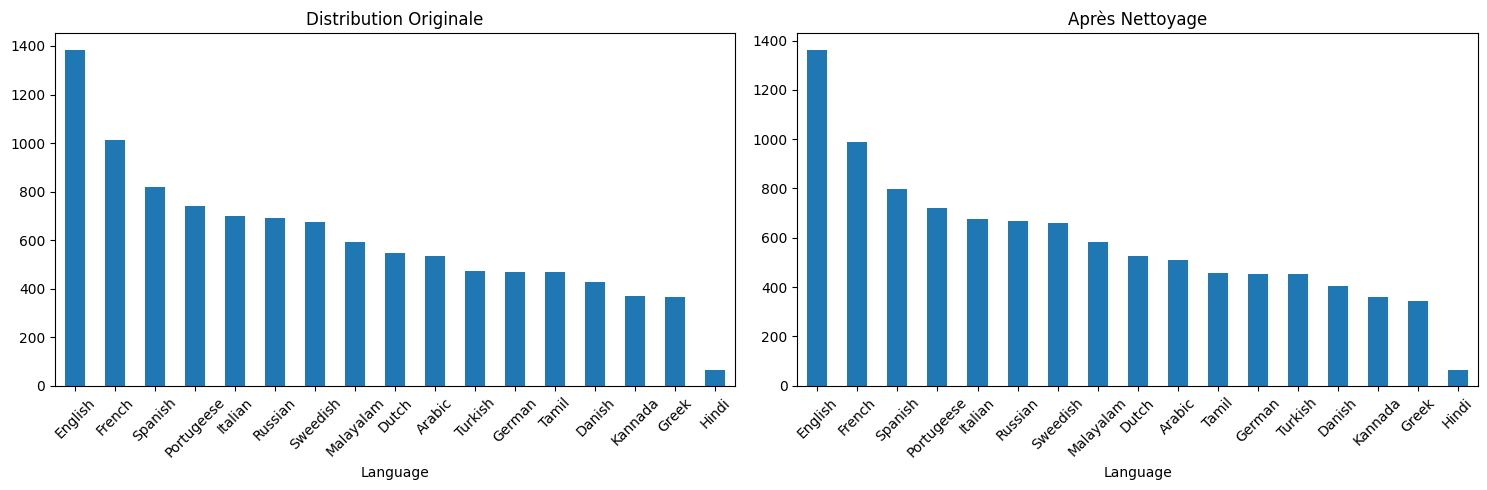

In [31]:
# Visualisons la comparaison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution originale
language_df['Language'].value_counts().plot(kind='bar', ax=axes[0], title='Distribution Originale')
axes[0].tick_params(axis='x', rotation=45)

# Distribution nettoyée
new_distribution.plot(kind='bar', ax=axes[1], title='Après Nettoyage')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## **Préparation des données pour la modélisation**
- Encodage des étiquettes
- Séparation train/val/test split
- Calcul des poids des classes pour gérer le déséquilibre
- Création d'une fonction de prétraitement cohérente

### **1. Encodage des langues**

In [32]:
# Aperću
print("\nAperću du dataset propre: ")
df_clean.head()


Aperću du dataset propre: 


,Text,Language,text_length,word_count,cleaned_text
1997,तब से विकिमीडिया ने कई अन्य परियोजनाएं शुरू की...,Hindi,19088,3735,तब से विकिमीडिया ने कई अन्य परियोजनाएं शुरू की...
1979,विकि-शब्दकोष (एक मुक्त शब्दकोष एवं समानांतर को...,Hindi,8752,1524,विकि शब्दकोष एक मुक्त शब्दकोष एवं समानांतर कोष...
2041,एक सेकंड पर लटकाओ। बस एक पल मेरे साथ सहन करो। ...,Hindi,8019,1766,एक सेकंड पर लटकाओ। बस एक पल मेरे साथ सहन करो। ...
1984,वह टिप्पणी देते हैं कि नॉन-फिक्शन के कई पारंपर...,Hindi,4068,739,वह टिप्पणी देते हैं कि नॉन फिक्शन के कई पारंपर...
1988,के कोरियाई होस्टिंग सुविधा सियोल में थीं।[104]...,Hindi,3678,649,के कोरियाई होस्टिंग सुविधा सियोल में थीं। तक व...


**Observation:** <br />
Textes hindi très long, cela pourrait fausser l'apprentissage et provoquer un surapprentissage.
On va tronquer les textes très longs.


In [33]:
text_length_by_language = df_clean.groupby('Language')['cleaned_text'].apply(lambda x: x.str.len().describe())
text_length_by_language

Language       
Arabic    count    509.000000
          mean      98.833006
          std       76.982266
          min       10.000000
          25%       42.000000
                      ...    
Turkish   min       10.000000
          25%       31.000000
          50%       78.000000
          75%      127.000000
          max      469.000000
Name: cleaned_text, Length: 136, dtype: float64

**Afin de tronquer les textes très longs. Nous devons choisir une limite de caractères raisonable. Analysons d'abord la distribution pour prendre une décision éclairée:**

### **Analysons la distribution des longueurs de texte**


In [34]:
longueurs = df_clean['cleaned_text'].str.len()

print("STATISTIQUES DE LONGUEUR DES TEXTES: \n")
print(f"Longueur moyenne: {longueurs.mean():.0f} caractères")
print(f"Écart-type: {longueurs.std():.0f} caractères")
print(f"Longueur minimale: {longueurs.min()}")
print(f"Longueur maximale: {longueurs.max()}")

STATISTIQUES DE LONGUEUR DES TEXTES: 

Longueur moyenne: 121 caractères
Écart-type: 237 caractères
Longueur minimale: 10
Longueur maximale: 17155


In [35]:
# Quartiles
print(f"\nQUARTILES: \n")
print(f"  25e percentile: {longueurs.quantile(0.25):.0f}")
print(f"  50e percentile (médiane): {longueurs.quantile(0.50):.0f}")
print(f"  75e percentile: {longueurs.quantile(0.75):.0f}")
print(f"  90e percentile: {longueurs.quantile(0.90):.0f}")
print(f"  95e percentile: {longueurs.quantile(0.95):.0f}")
print(f"  99e percentile: {longueurs.quantile(0.99):.0f}")


QUARTILES: 

  25e percentile: 45
  50e percentile (médiane): 97
  75e percentile: 160
  90e percentile: 229
  95e percentile: 278
  99e percentile: 436


**Basé sur ces stats, le 95e percentile (278 caractères) semble être un bon compromis étant donné que ća couvre 95% de tous les textes. Le 99e percentile (436 caractères) est beaucoup trop élévé sans doute à cause des cas extrêmes**

In [36]:
# Appliquons la troncature
seuil = 278  # 95e percentile

df_clean['text_final'] = df_clean['cleaned_text'].apply(
  lambda x: x[:seuil] if len(x) > seuil else x
)

print(f"\nTroncature appliquée avec un seuil de {seuil} caractères")
print(f"Longueur max avant: {df_clean['cleaned_text'].str.len().max()}")
print(f"Longueur max après: {df_clean['text_final'].str.len().max()}")



Troncature appliquée avec un seuil de 278 caractères
Longueur max avant: 17155
Longueur max après: 278


In [37]:
# Vérifions l'impact par langue
print("\nImpact par langue (longueur moyenne avant -> après):")
for langue in df_clean['Language'].unique():
	avant = df_clean[df_clean['Language'] == langue]['cleaned_text'].str.len().mean()
	apres = df_clean[df_clean['Language'] == langue]['text_final'].str.len().mean()
	if avant > seuil:  # Seulement les langues avec des textes longs
		print(f"Langue avec texte long, {langue}: {avant:.0f} -> {apres:.0f} caractères")


Impact par langue (longueur moyenne avant -> après):
Langue avec texte long, Hindi: 1159 -> 170 caractères


**Encodons les langues**

In [38]:
label_encoder = LabelEncoder()
df_clean['language_encoded'] = label_encoder.fit_transform(df_clean['Language'])
print("\nMAPPING LANGUE -> CODE")
for lang, code in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
  print(f"{lang}: {code}")


MAPPING LANGUE -> CODE
Arabic: 0
Danish: 1
Dutch: 2
English: 3
French: 4
German: 5
Greek: 6
Hindi: 7
Italian: 8
Kannada: 9
Malayalam: 10
Portugeese: 11
Russian: 12
Spanish: 13
Sweedish: 14
Tamil: 15
Turkish: 16


In [39]:
## Exportons le dataset final
df_final = df_clean[['text_final', 'language_encoded', 'Language']].copy()
print("DATASET FINAL: \n")
print(df_final.info())
print(f"\nAperću des 05 dernières lignes: ")
df_final[-5:].head()

DATASET FINAL: 

<class 'pandas.core.frame.DataFrame'>
Index: 10021 entries, 1997 to 5917
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   text_final        10021 non-null  object
 1   language_encoded  10021 non-null  int64 
 2   Language          10021 non-null  object
dtypes: int64(1), object(2)
memory usage: 313.2+ KB
None

Aperću des 05 dernières lignes: 


,text_final,language_encoded,Language
9688,komm schon,5,German
1289,permission,3,English
8892,stort tack,14,Sweedish
9431,مليون شكرا,0,Arabic
5917,ναι φυσικά,6,Greek


In [40]:
# Sauvegarder en CSV
output_path = '../data/processed/language_detection_clean.csv'
df_final.to_csv(output_path, index=False)
print(f"\nDataset exporté avec succès vers: {output_path}")
print(f"Taille du fichier: {os.path.getsize(output_path) / 1024:.2f} KB")


Dataset exporté avec succès vers: ../data/processed/language_detection_clean.csv
Taille du fichier: 1583.69 KB


In [41]:
# Vérification rapide
df = pd.read_csv(output_path)
print(f"{len(df)} lignes chargées")
df[-5:].head()

10021 lignes chargées


,text_final,language_encoded,Language
10016,komm schon,5,German
10017,permission,3,English
10018,stort tack,14,Sweedish
10019,مليون شكرا,0,Arabic
10020,ναι φυσικά,6,Greek


**Définissons X et y proprement**

In [42]:
X = df['text_final'].values
y = df['language_encoded'].values

print(f"X: {len(X)} textes")
print(f"y: {len(y)} étiquettes (valeurs entre 0 à {y.max()})")
print(f"\nDistribution des langues: ")
df['Language'].value_counts()

X: 10021 textes
y: 10021 étiquettes (valeurs entre 0 à 16)

Distribution des langues: 


Language
English       1363
French         988
Spanish        797
Portugeese     720
Italian        676
Russian        668
Sweedish       659
Malayalam      581
Dutch          528
Arabic         509
Tamil          457
German         453
Turkish        453
Danish         404
Kannada        358
Greek          345
Hindi           62
Name: count, dtype: int64

### **2. Division en Train/Val/Test**

In [43]:
print("\nDIVISION DES DONNÉES: \n")

# Séparons train+val / test (80-20)
X_temp, X_test, y_temp, y_test = train_test_split(
	X, y, 
	test_size=0.2, 
	random_state=42, 
	stratify=y
)

# Séparons train+val en train / val (75-25 de temp = 60-20-20 final)
X_train, X_val, y_train, y_val = train_test_split(
	X_temp, y_temp, 
	test_size=0.25, 
	random_state=42, 
	stratify=y_temp
)

print(f"Taille totale du dataset: {len(X)} échantillons")
print(f"\nEnsembles:")
print(f"  -> Entraînement: {len(X_train):6d} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  -> Validation:   {len(X_val):6d} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  -> Test:         {len(X_test):6d} ({len(X_test)/len(X)*100:.1f}%)")

# Vérification rapide
print(f"\nTotal: {len(X_train) + len(X_val) + len(X_test)}/{len(X)}")


DIVISION DES DONNÉES: 

Taille totale du dataset: 10021 échantillons

Ensembles:
  -> Entraînement:   6012 (60.0%)
  -> Validation:     2004 (20.0%)
  -> Test:           2005 (20.0%)

Total: 10021/10021


In [44]:
# Vérifions la distribution d'une langue spécifique pour s'assurer que le stratify a fonctionné
hindi_code = 7  # code de Hindi
english_code = 3

print(f"\nVérification distribution Hindi (code {hindi_code}):")
print(f"  Train: {(y_train == hindi_code).sum():3d} échantillons")
print(f"  Val:   {(y_val == hindi_code).sum():3d} échantillons")
print(f"  Test:  {(y_test == hindi_code).sum():3d} échantillons")
print(f"  Total: {(y == hindi_code).sum():3d} échantillons dans le dataset original")

print(f"\nVérification distribution English (code {english_code}):")
print(f"  Train: {(y_train == english_code).sum():3d} échantillons")
print(f"  Val:   {(y_val == english_code).sum():3d} échantillons")
print(f"  Test:  {(y_test == english_code).sum():3d} échantillons")
print(f"  Total: {(y == english_code).sum():3d} échantillons dans le dataset original")


Vérification distribution Hindi (code 7):
  Train:  37 échantillons
  Val:    13 échantillons
  Test:   12 échantillons
  Total:  62 échantillons dans le dataset original

Vérification distribution English (code 3):
  Train: 818 échantillons
  Val:   272 échantillons
  Test:  273 échantillons
  Total: 1363 échantillons dans le dataset original


**Calculons le poids des classes pour se rassurer que le déséquilibre est bien intégré**

In [45]:
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weight_dict = dict(zip(classes, class_weights))

print("Poids des classes:")
for code, poids in class_weight_dict.items():
    langue = df[df['language_encoded'] == code]['Language'].iloc[0]
    print(f"{langue}: {poids:.4f}")

Poids des classes:
Arabic: 1.1595
Danish: 1.4614
Dutch: 1.1156
English: 0.4323
French: 0.5964
German: 1.3002
Greek: 1.7084
Hindi: 9.5580
Italian: 0.8711
Kannada: 1.6449
Malayalam: 1.0133
Portugeese: 0.8186
Russian: 0.8841
Spanish: 0.7398
Sweedish: 0.8953
Tamil: 1.2860
Turkish: 1.3050


**Plus petit est le nombre, le plus la langue est majoritaire dans le dataset, inversement le plus grand est le nombre, le plus minoritaire cette langue est dans le dataset.**
- **Hindi très minoritaire a le plus grand nombre**
- **English, le plus majoritaire a le plus petit nombre**

**Conclusion, le déséquilibre est bien géré dans le dataset.**

### **3. Tokenization & Embeddings**

**Nous faisons la tokenization, au niveau caractères (`character-based`)**
- La détection de langue repose sur des motifs de caractères (suites de lettres, accents, caractères spéciaux) plutôt que sur le sens des mots
- C'est robuste, car ća fonctionne pour toutes les langes, même celles inconnues ou avec des mots hors vocabulaire
- Réduit la taille du vocabulaire, quelques centaines de caractères vs des milliers avec des mots.

fun fact: c'est utilisé par des modèles comme langid.py ou fastText pour la détection de langue

**On commence par construire le vocabulaire à partir des caractères**

In [46]:
vocab = build_vocab(X_train)
vocab_size = len(vocab)

print(f"Taille du vocabulaire: {vocab_size}")
print(f"Tokens spéciaux: <PAD>={vocab['<PAD>']}, <UNK>={vocab['<UNK>']}")
print(f"\nAperću des 10 premiers caractères: {list(vocab.items())[:10]}")

Taille du vocabulaire: 418
Tokens spéciaux: <PAD>=0, <UNK>=1

Aperću des 10 premiers caractères: [('<PAD>', 0), ('<UNK>', 1), (' ', 2), ('e', 3), ('a', 4), ('i', 5), ('n', 6), ('t', 7), ('o', 8), ('r', 9)]


In [47]:
# Tester sur un exemple, la conversion d'un texte en séquence

test_text = X_train[0]
test_seq = text_to_sequence(test_text, vocab, src.preprocess.max_length)
print(f"Texte original (extrait): {test_text[:100]}...")
print(f"Séquence générée (longueur): {len(test_seq)}")
print(f"Premiers 20 identifiants: {test_seq[:20]}")

Texte original (extrait): in an atrocious manner sometimes in prisons atrocious is also used in day to day life to talk about ...
Séquence générée (longueur): 278
Premiers 20 identifiants: [5, 6, 2, 4, 6, 2, 4, 7, 9, 8, 14, 5, 8, 13, 10, 2, 15, 4, 6, 6]


In [48]:
# Créons les datasets
train_dataset = LanguageDataset(X_train, y_train, vocab, src.preprocess.max_length)
val_dataset = LanguageDataset(X_val, y_val, vocab, src.preprocess.max_length)
test_dataset = LanguageDataset(X_test, y_test, vocab, src.preprocess.max_length)

print(f"Train: {len(train_dataset)} échantillons")
print(f"Val: {len(val_dataset)} échantillons")
print(f"Test: {len(test_dataset)} échantillons")

Train: 6012 échantillons
Val: 2004 échantillons
Test: 2005 échantillons


In [49]:
# Créer les dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nTrain loader: {len(train_loader)} batches de {batch_size}")
print(f"Val loader: {len(val_loader)} batches")
print(f"Test loader: {len(test_loader)} batches")


Train loader: 188 batches de 32
Val loader: 63 batches
Test loader: 63 batches


In [50]:
# Vérifier un batch
batch = next(iter(train_loader))
print(f"\nForme d'un batch:")
print(f"  input_ids: {batch['input_ids'].shape}")
print(f"  labels: {batch['label'].shape}")


Forme d'un batch:
  input_ids: torch.Size([32, 278])
  labels: torch.Size([32])


## **Modélisation (`LanguageDetectorLSTM`)**

In [51]:
from src.model import LanguageDetectorLSTM

# Paramètres du modèle
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 256
num_classes = len(np.unique(y))
n_layers = 2
dropout = 0.3

model = LanguageDetectorLSTM(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                            num_classes=num_classes, n_layers=n_layers, dropout=dropout)
print(f"\nTotal des paramètres: {sum(p.numel() for p in model.parameters())}")
# Aperću du model
print(f"\nAperću du model: \n{model}")


Total des paramètres: 979473

Aperću du model: 
LanguageDetectorLSTM(
  (embedding): Embedding(418, 128, padding_idx=0)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=17, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


**Description de l'architecture**

- Embedding : transforme les identifiants en vecteurs denses (128 dimensions)
- LSTM : capture les dépendances séquentielles (2 couches, 256 hidden)
- Padding_idx=0 : ignore les tokens <PAD> dans l'embedding
- Dropout : réduit le surapprentissage

## **Entraînement du Modèle**

In [52]:
from src.train import train_epoch
from src.evaluate import evaluate

In [53]:
# Paramètres d'entraînement
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [54]:
# Fonction de perte avec poids des classes
class_weights_tensor = torch.tensor([class_weight_dict[i] for i in range(num_classes)], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [55]:
# Optimiseur
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [56]:
# Boucle d'entraînement
num_epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
  train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
  val_loss, val_acc = evaluate(model, val_loader, criterion, device)
  
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accs.append(train_acc)
  val_accs.append(val_acc)
  
  print(f"Epoch {epoch+1}/{num_epochs}")
  print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
  print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

KeyboardInterrupt: 

**Implémentons une nouvelle boucle d'entrâinement avec `Early Stopping` et une `Patience`**

In [ ]:
# Paramètres early stopping
patience = 10
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
  train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
  val_loss, val_acc = evaluate(model, val_loader, criterion, device)
  
  print(f"Epoch {epoch+1}/{num_epochs}")
  print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
  print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
  
  # Early stopping
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model_state = model.state_dict().copy()
    patience_counter = 0
    
    # Sauvegarde du meilleur modèle
    model_path = f'../models/lstm_langdetect_epoch{epoch+1}_valloss{val_loss:.4f}.pt'
    torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'val_loss': val_loss,
      'vocab': vocab,
      'class_weight_dict': class_weight_dict
    }, model_path)
    print(f" -> Modèle sauvegardé: {model_path}")
  else:
    patience_counter += 1
    if patience_counter >= patience:
      print(f"Early stopping à l'époque {epoch+1}")
      break
    

# Sauvegarde aussi du modèle final
final_path = '../models/lstm_langdetect_final.pt'
torch.save({
  'model_state_dict': model.state_dict(),
  'vocab': vocab,
  'class_weight_dict': class_weight_dict
}, final_path)
print(f"\nModèle final sauvegardé: {final_path}")

Epoch 1/10
  Train Loss: 2.7580, Train Acc: 0.0629
  Val Loss: 2.7843, Val Acc: 0.0619
 -> Modèle sauvegardé: ../models/lstm_langdetect_epoch1_valloss2.7843.pt
Epoch 2/10
  Train Loss: 2.7602, Train Acc: 0.0659
  Val Loss: 2.7832, Val Acc: 0.0988
 -> Modèle sauvegardé: ../models/lstm_langdetect_epoch2_valloss2.7832.pt
Epoch 3/10
  Train Loss: 2.7584, Train Acc: 0.0730
  Val Loss: 2.7866, Val Acc: 0.0419
Epoch 4/10
  Train Loss: 2.5449, Train Acc: 0.1016
  Val Loss: 2.2366, Val Acc: 0.1063
 -> Modèle sauvegardé: ../models/lstm_langdetect_epoch4_valloss2.2366.pt
Epoch 5/10
  Train Loss: 2.2496, Train Acc: 0.1093
  Val Loss: 2.1832, Val Acc: 0.1223
 -> Modèle sauvegardé: ../models/lstm_langdetect_epoch5_valloss2.1832.pt
Epoch 6/10
  Train Loss: 2.1202, Train Acc: 0.1475
  Val Loss: 2.0322, Val Acc: 0.1582
 -> Modèle sauvegardé: ../models/lstm_langdetect_epoch6_valloss2.0322.pt
Epoch 7/10
  Train Loss: 1.9854, Train Acc: 0.1655
  Val Loss: 1.7652, Val Acc: 0.1672
 -> Modèle sauvegardé: ../

## **Évaluation du meilleur Modèle**

In [ ]:
# Récupération du modèle final, et reconstruction du modèle avec les mêmes paramètres
final_path = '../models/lstm_langdetect_final.pt'
checkpoint = torch.load(final_path, map_location=device, weights_only=False) ## weights_only=False

# Reconstruire le modèle avec les mêmes paramètres
vocab_size = len(checkpoint['vocab'])
embedding_dim = 128
hidden_dim = 256
num_classes = len(checkpoint['class_weight_dict'])
n_layers = 2
dropout = 0.3

# Recréons l'architecture
model = LanguageDetectorLSTM(vocab_size, embedding_dim, hidden_dim, num_classes, n_layers, dropout)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

LanguageDetectorLSTM(
  (embedding): Embedding(418, 128, padding_idx=0)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=17, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
print("Modèle chargé avec succès")
print(f"Vocabulaire: {vocab_size} tokens")
print(f"Classes: {num_classes} langues")

Modèle chargé avec succès
Vocabulaire: 418 tokens
Classes: 17 langues


In [ ]:
# Évaluation sur le test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 1.2581, Test Acc: 0.4100


In [ ]:
# Obtenons les prédictions pour l'analyse détaillée
y_pred, y_true = get_predictions(model, test_loader, device)

In [ ]:
# Rapport de classification
langues = [df[df['language_encoded'] == i]['Language'].iloc[0] for i in range(num_classes)]
print("\nRapport de classification:")
print(classification_report(y_true, y_pred, target_names=langues))


Rapport de classification:
              precision    recall  f1-score   support

      Arabic       1.00      0.98      0.99       102
      Danish       0.28      0.83      0.42        81
       Dutch       0.29      0.02      0.04       106
     English       0.90      0.81      0.85       273
      French       0.00      0.00      0.00       198
      German       0.25      0.20      0.22        91
       Greek       0.00      0.00      0.00        69
       Hindi       1.00      1.00      1.00        12
     Italian       0.30      0.26      0.28       135
     Kannada       0.96      0.99      0.97        71
   Malayalam       0.00      0.00      0.00       116
  Portugeese       0.00      0.00      0.00       144
     Russian       0.00      0.00      0.00       134
     Spanish       0.25      0.78      0.38       159
    Sweedish       0.58      0.11      0.18       132
       Tamil       0.22      1.00      0.36        91
     Turkish       0.32      0.76      0.45        91

/home/kevin/anaconda3/envs/projet_ifm31115/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/kevin/anaconda3/envs/projet_ifm31115/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/kevin/anaconda3/envs/projet_ifm31115/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

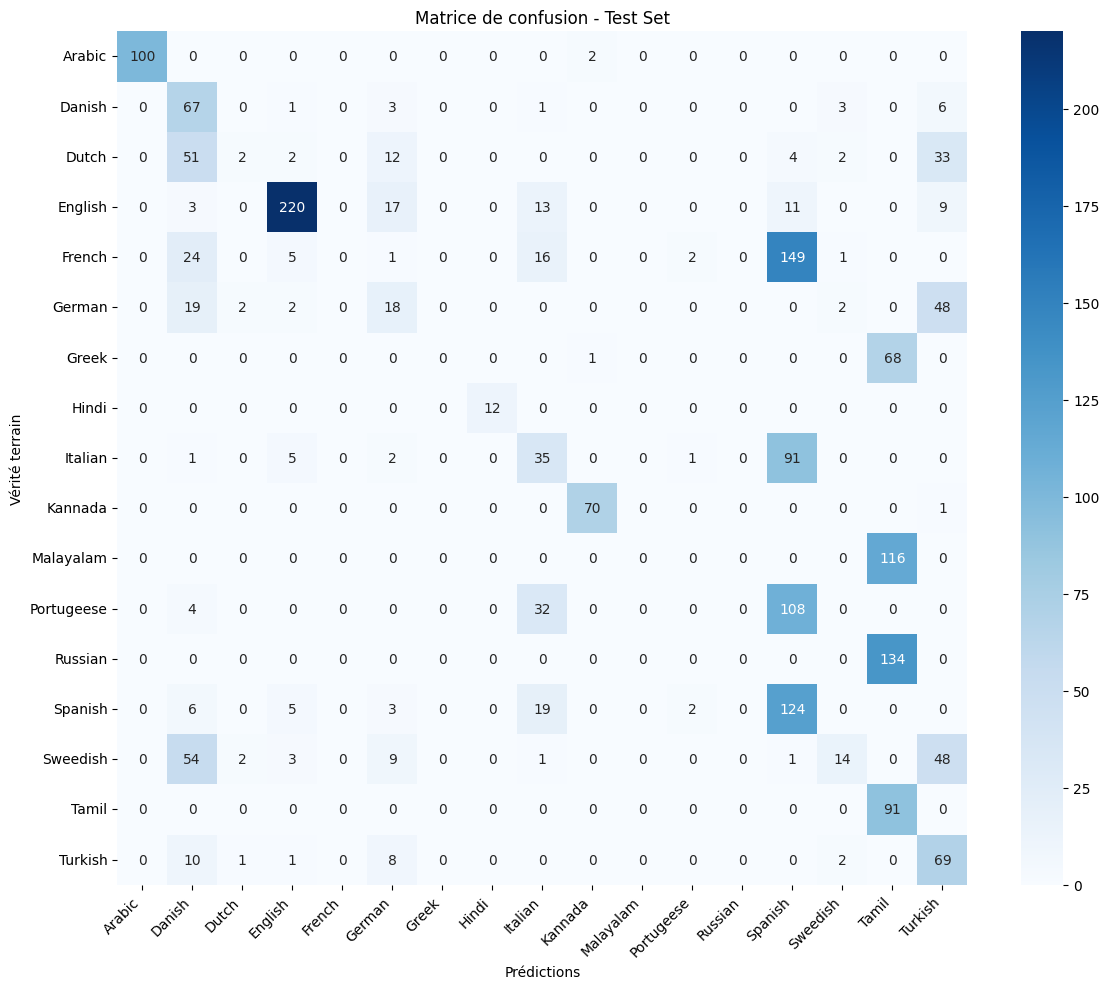

In [ ]:
# Matrice de confusion
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=langues, yticklabels=langues)
plt.title('Matrice de confusion - Test Set')
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### **Analyse**: <br />
- L'analyse des résultats montre que le modèle performe très mal avec une accuracy globale de seulement 41%. Les langues à écriture non-latine comme l'arabe, l'hindi et le kannada sont parfaitement reconnues (F1-score > 0.97), mais les langues européennes partageant l'alphabet latin sont constamment confondues entre elles. Le français, le grec, le malayalam, le portugais et le russe n'ont jamais été correctement prédits, tandis que l'anglais domine massivement les prédictions en étant attribué par erreur à de nombreux échantillons d'autres langues.
- La matrice de confusion révèle deux problèmes majeurs : d'une part les langues germaniques (danois, néerlandais, allemand, suédois) sont constamment mélangées entre elles, et d'autre part les langues romanes (français, espagnol, portugais, italien) sont indistinguables pour le modèle. Cette confusion généralisée indique que l'architecture LSTM utilisée est trop simple pour capturer les nuances subtiles entre langues apparentées, et que la tokenisation au niveau caractères ne fournit pas assez d'information discriminante.


# **Amélioration du Modèle: `Tokenization SentencePiece` + `BiLSTM`**

L'évaluation du premier modèle (tokenisation caractères + LSTM simple) nous a démontré des performances limitées (accuracy 41%), alors nous procédons à une amélioration significative de l'architecture.

**Problèmes identifiés :**
- Confusion entre langues partageant le même alphabet (français/espagnol, danois/suédois)
- Incapacité à capturer les motifs linguistiques discriminants
- Dépendances longues mal modélisées

**Solution proposée :**
1. **Tokenisation sous-mots (SentencePiece)** : remplace la tokenisation caractères par des unités linguistiques plus pertinentes (morphèmes, syllabes, mots fréquents)
2. **BiLSTM profond** : remplace le LSTM simple par un réseau bidirectionnel de 3 couches pour mieux capturer le contexte dans les deux directions

**Objectif :** Atteindre une accuracy >70% en améliorant la discrimination des langues similaires.

Les données (X_train, X_val, X_test, y_train, y_val, y_test) sont déjà préparées et inchangées. Nous allons uniquement modifier la façon dont les textes sont tokenisés et l'architecture du modèle

In [ ]:
# Vérification que X_train est toujours disponible
print(f"X_train: {len(X_train)} échantillons")
print(f"Exemple: {X_train[0][:100]}...")

X_train: 6012 échantillons
Exemple: in an atrocious manner sometimes in prisons atrocious is also used in day to day life to talk about ...


### **1. Tokenization SentencePiece**

In [ ]:
# Créons un fichier temporaire avec les textes pour l'entrâinement - 
# Ceci parce-que sentencepiece ne prends pas des listes python en entrée, juste un fichier
with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.txt', encoding='utf-8') as f:
    for text in X_train:
        f.write(text + '\n')
    train_path = f.name

print(f"Fichier temporaire créé: {train_path}")
print(f"   {len(X_train)} lignes écrites")

# Afficher les premières lignes pour vérification
print("\nAperçu du fichier:")
with open(train_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i < 3:
            print(f"  Ligne {i+1}: {line[:100]}...")
        else:
            break

Fichier temporaire créé: /tmp/tmpcvds9hbt.txt
   6012 lignes écrites

Aperçu du fichier:
  Ligne 1: in an atrocious manner sometimes in prisons atrocious is also used in day to day life to talk about ...
  Ligne 2: أريد أن أستمر لست متعبًا من ذلك عندما يسألك أحدهم هل أنت متأكد وأنت متأكد تمامًا من أنه لا يوجد مكان...
  Ligne 3: orsaken kan vara att olika delar har redigerats av olika bidragsgivare med olika grad av språkliga f...


### **Entraînons le modèle `SentencePiece`**

In [ ]:
# Entrainement du SentencePiece sur les données de train
spm.SentencePieceTrainer.train(
	input=train_path,
	model_prefix='spm_lang_detector',
	vocab_size=8000,
	character_coverage=1.0,
	model_type='unigram',
	pad_id=0,
	unk_id=1,
	bos_id=2,
	eos_id=3,
	pad_piece='<pad>',
	unk_piece='<unk>',
	bos_piece='<s>',
	eos_piece='</s>'
)

print("Modèle SentencePiece entraîné")
print("Fichiers générés:")
print("  - spm_lang_detector.model")
print("  - spm_lang_detector.vocab")

Modèle SentencePiece entraîné
Fichiers générés:
  - spm_lang_detector.model
  - spm_lang_detector.vocab


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /tmp/tmpcvds9hbt.txt
  input_format: 
  model_prefix: spm_lang_detector
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy

Parfait. L'entraînement s'est bien déroulé :

- 6012 phrases traitées
- 413 caractères uniques dans l'alphabet
- 8000 tokens sous-mots générés
- Alphabet suffisamment large pour couvrir toutes les langues (unicode)

In [ ]:
# Chargeons le modèle
sp = spm.SentencePieceProcessor()
sp.load('spm_lang_detector.model')

print(f"Taille du vocabulaire: {sp.get_piece_size()}")
print(f"\nExemples de tokens sous-mots:")
for i in range(20):
    print(f"  {i}: {sp.id_to_piece(i)}")

Taille du vocabulaire: 8000

Exemples de tokens sous-mots:
  0: <pad>
  1: <unk>
  2: <s>
  3: </s>
  4: ▁
  5: s
  6: e
  7: ▁de
  8: t
  9: i
  10: o
  11: a
  12: n
  13: r
  14: ▁the
  15: ▁en
  16: ▁la
  17: ▁in
  18: d
  19: m


In [ ]:
# Test sur un exemple
test_text = X_train[0]
ids = sp.encode(test_text, out_type=int)
pieces = sp.encode(test_text, out_type=str)

print(f"\nTexte original: {test_text[:100]}...")
print(f"Tokens: {pieces[:20]}")
print(f"IDs: {ids[:20]}")
print(f"Longueur: {len(ids)} tokens")


Texte original: in an atrocious manner sometimes in prisons atrocious is also used in day to day life to talk about ...
Tokens: ['▁in', '▁an', '▁atrocious', '▁manner', '▁some', 't', 'imes', '▁in', '▁pri', 's', 'ons', '▁atrocious', '▁is', '▁also', '▁used', '▁in', '▁day', '▁to', '▁day', '▁life']
IDs: [17, 113, 2990, 4452, 560, 8, 2716, 17, 925, 5, 1854, 2990, 51, 640, 1016, 17, 2880, 29, 2880, 753]
Longueur: 39 tokens


<u>**Observations:**</u>

- ▁ représente l'espace (début de mot)
- Des mots entiers sont capturés : ▁atrocious, ▁manner, ▁day
- Des sous-mots pertinents : ▁some + t + imes = "sometimes"
- Longueur moyenne : 39 tokens (vs 278 caractères max)

**Conséquence : Avec 39 tokens en moyenne, notre max_length=278 est très confortable. On pourrait même le réduire pour accélérer l'entraînement, mais on garde 278 pour l'instant.**

In [ ]:
# Test de notre fonction de conversion `texte` -> `séquence`

test_seq = text_to_subword_sequence(test_text, sp, src.preprocess.max_length)
print(f"Longueur de la séquence: {len(test_seq)}")
print(f"Premiers 20 IDs: {test_seq[:20]}")
print(f"Derniers 20 IDs: {test_seq[-20:]} (doivent être des 0 pour le padding)")

Longueur de la séquence: 278
Premiers 20 IDs: [17, 113, 2990, 4452, 560, 8, 2716, 17, 925, 5, 1854, 2990, 51, 640, 1016, 17, 2880, 29, 2880, 753]
Derniers 20 IDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (doivent être des 0 pour le padding)


**Recréons les datasets**


In [ ]:
# Les datasets
train_dataset_sub = SubwordLanguageDataset(X_train, y_train, sp, src.preprocess.max_length)
val_dataset_sub = SubwordLanguageDataset(X_val, y_val, sp, src.preprocess.max_length)
test_dataset_sub = SubwordLanguageDataset(X_test, y_test, sp, src.preprocess.max_length)

print(f"Train dataset: {len(train_dataset_sub)} échantillons")
print(f"Val dataset: {len(val_dataset_sub)} échantillons")
print(f"Test dataset: {len(test_dataset_sub)} échantillons")

Train dataset: 6012 échantillons
Val dataset: 2004 échantillons
Test dataset: 2005 échantillons


**Recréons les dataloaders**

In [ ]:
# Les dataloaders
batch_size = 32
train_loader_sub = DataLoader(train_dataset_sub, batch_size=batch_size, shuffle=True)
val_loader_sub = DataLoader(val_dataset_sub, batch_size=batch_size, shuffle=False)
test_loader_sub = DataLoader(test_dataset_sub, batch_size=batch_size, shuffle=False)

print(f"\nTrain loader: {len(train_loader_sub)} batches")
print(f"Val loader: {len(val_loader_sub)} batches")
print(f"Test loader: {len(test_loader_sub)} batches")


Train loader: 188 batches
Val loader: 63 batches
Test loader: 63 batches


In [ ]:
# Vérifions le contenu d'un batch
sample_batch = next(iter(train_loader_sub))
print(f"\nForme d'un batch:")
print(f"  input_ids: {sample_batch['input_ids'].shape}")
print(f"  labels: {sample_batch['label'].shape}")


Forme d'un batch:
  input_ids: torch.Size([32, 278])
  labels: torch.Size([32])


### **2. Le Modèle `BiLSTM` et Training**

In [ ]:
from src.model import BiLSTMSubword # Import du modèle

# Paramètres du modèle
vocab_size = 8000  # Taille du vocabulaire SentencePiece
embedding_dim = 256
hidden_dim = 512
num_classes = len(np.unique(y_train))
n_layers = 3
dropout = 0.5

model = BiLSTMSubword(vocab_size, embedding_dim, hidden_dim, num_classes, n_layers, dropout)
print(model)
print(f"\nParamètres totaux: {sum(p.numel() for p in model.parameters()):,}")

BiLSTMSubword(
  (embedding): Embedding(8000, 256, padding_idx=0)
  (lstm): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=1024, out_features=17, bias=True)
)

Paramètres totaux: 17,818,641


In [ ]:
# Définir le device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Modèle entraîné sur: {device}")

# Poids des classes (calculés précédemment)
class_weights_tensor = torch.tensor([class_weight_dict[i] for i in range(num_classes)], dtype=torch.float).to(device)

# Fonction de perte et optimiseur
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

NameError: name 'torch' is not defined

**Entraînement du modèle `BiLSTM` avec 17.8 Millions de paramètres**

In [ ]:
# Lancement du training avec `Early Stopping` et `Patience`
# Paramètres d'entraînement
num_epochs = 20
patience = 10
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
  # Entraînement
  train_loss, train_acc = train_epoch(model, train_loader_sub, criterion, optimizer, device)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  
  # Validation
  val_loss, val_acc = evaluate(model, val_loader_sub, criterion, device)
  val_losses.append(val_loss)
  val_accs.append(val_acc)
  
  print(f"Epoch {epoch+1}/{num_epochs}")
  print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
  print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
  
  # Early stopping
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model_state = model.state_dict().copy()
    patience_counter = 0
    print(f"  -> Meilleur modèle sauvegardé (val_loss: {val_loss:.4f})")
  else:
    patience_counter += 1
    print(f"  -> Patience: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
      print(f"Early stopping à l'époque {epoch+1}")
      break

# Restaurer le meilleur modèle
if best_model_state:
  model.load_state_dict(best_model_state)
  print(f"\nMeilleur modèle restauré (val_loss: {best_val_loss:.4f})")

# Sauvegarde du modèle final
torch.save({
  'model_state_dict': model.state_dict(),
  'vocab_size': vocab_size,
  'embedding_dim': embedding_dim,
  'hidden_dim': hidden_dim,
  'num_classes': num_classes,
  'n_layers': n_layers,
  'dropout': dropout,
  'class_weight_dict': class_weight_dict,
  'sp_model': sp.serialized_model_proto()  # Sauvegarde du tokenizer
}, '../models/bilstm_subword_final.pt')

print("Modèle sauvegardé dans ../models/bilstm_subword_final.pt")